使用质心法进行目标追踪

作者：谢文伟

邮件：xiewenwei@sina.com

主页：https://github.com/jimxie2012/ai-cv

导入库

In [1]:
import cv2,math
import numpy as np
import IPython.display as display
from yolo_detect import Init_Yolo,Detect,Draw #封装YOLO模型的检测操作
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #在统计图上显示中文

In [2]:
model,labels = Init_Yolo('./models/yolov3-tiny.cfg',
                         './models/yolov3-tiny.weights',
                         './models/coco.names')

读取两帧图像

In [3]:
frame_1 = cv2.imread('./images/ball_1.png')
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB) 
frame_2 = cv2.imread('./images/ball_2.png')
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)

对这两帧图像进行目标检测（这里只检测足球，忽略掉其他目标）

In [4]:
#使用YOLO检测两帧图像中的目标
b1 = Detect(model,labels,frame_1)
b2 = Detect(model,labels,frame_2)
#只保留足球的检测结果
filter=np.where(b1[:,-1]=='sports ball')  
bbox1 = b1[filter]
filter=np.where(b2[:,-1]=='sports ball')  
bbox2 = b2[filter]

显示检测结果

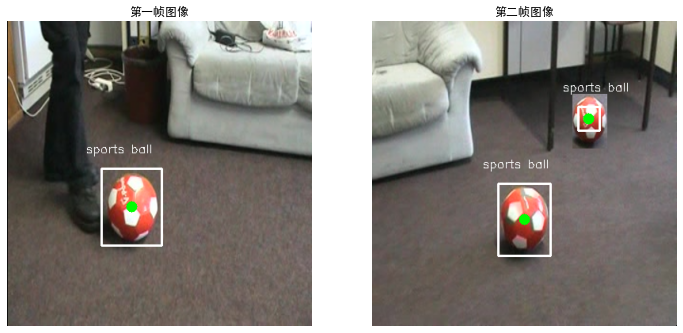

In [5]:
mask1 = Draw(frame_1,bbox1)  #绘制在第一帧中检测到的目标
mask2 = Draw(frame_2,bbox2)  #绘制在第二帧中检测到的目标
#显示检测结果
fig = plt.figure(figsize=(12,10))
def ShowImg(id,title,img):
    ax=fig.add_subplot(1,2,id)
    ax.imshow(img)
    ax.axis('off')
    plt.title(title)
ShowImg(1,'第一帧图像',mask1)
ShowImg(2,'第二帧图像',mask2)

计算质心坐标

In [6]:
A = (int(bbox1[0][0])+int(bbox1[0][2])/2,int(bbox1[0][1])+int(bbox1[0][3])/2)
B = (int(bbox2[1][0])+int(bbox2[1][2])/2,int(bbox2[1][1])+int(bbox2[1][3])/2)
C = (int(bbox2[0][0])+int(bbox2[0][2])/2,int(bbox2[0][1])+int(bbox2[0][3])/2)
print("第一帧目标A",A,"第二帧目标B",B,"第二帧目标C",C)

第一帧目标A (157.0, 234.5) 第二帧目标B (273.5, 123.0) 第二帧目标C (192.0, 250.5)


计算第一帧中的目标和后一帧中目标的欧氏距离

In [7]:
AB = math.sqrt(math.pow((A[0]-B[0]),2)+math.pow((A[1]-B[1]),2))
AC = math.sqrt(math.pow((A[0]-C[0]),2)+math.pow((A[1]-C[1]),2))
print("AB距离",AB,"AC距离",AC,"AC是同一目标")

AB距离 161.25910826988968 AC距离 38.48376280978771 AC是同一目标


显示追踪结果

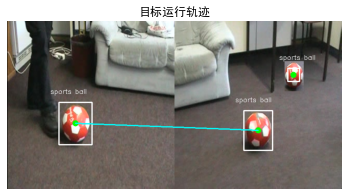

In [8]:
mask1 = Draw(frame_1,bbox1)  #绘制在第一帧中检测到的目标
mask2 = Draw(frame_2,bbox2)  #绘制在第二帧中检测到的目标
all_img = np.hstack((mask1, mask2)) #将两帧图像合并成一幅图像
#绘制运动轨迹
H,W = mask1.shape[:2]
cv2.line(all_img,(int(A[0]),int(A[1])),(W+int(C[0]),int(C[1])),(0,255,255),2)
##显示追踪结果
plt.title('目标运行轨迹')
plt.axis('off')
plt.imshow(all_img)

视频中的目标跟踪演示（只演示追踪单个目标）

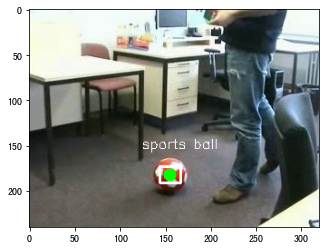

In [12]:
cap = cv2.VideoCapture("./video/ball.mp4")#打开视频文件
pre_bbox = None
count = 0
while True:
    ret,frame = cap.read()     #读取视频的帧
    if not ret:                #视频文件读取结束
        break
    count=count+1
    if count < 15 :
        continue
    count = 0
    rgb_img= cv2.cvtColor(frame.copy(),cv2.COLOR_BGR2RGB)#将视频的帧转换为RGB格式
    b = Detect(model,labels,rgb_img)
    filter=np.where(b1[:,-1]=='sports ball')#只保留足球的检测结果
    if len(b)>0:
        cur_bbox = b[filter]
        if len(cur_bbox) > 0:
            #如果是首次发现目标，初始化该目标轨迹
            if pre_bbox is None:
                pre_bbox = cur_bbox  
            #查找上一帧中的目标，在当前帧中最相近的目标位置
            for box1 in pre_bbox:
                p1 = (int(box1[0])+int(box1[2])/2,int(box1[1])+int(box1[3])/2)
                min_dis = 65535
                min_box = None
                for box2 in cur_bbox:
                    p2 = (int(box2[0])+int(box2[2])/2,int(box2[1])+int(box2[3])/2)
                    d = math.sqrt(math.pow((p1[0]-p2[0]),2)+math.pow((p1[1]-p2[1]),2))
                    if d < min_dis and d < 1024:
                        min_dis = d
                        min_box = box2
                #距离太远，没有找到，注销该目标的轨迹
                if min_box is None:
                    pre_bbox = None     
                    continue
                #找到该目标，在图像上标注出来
                rgb_img = Draw(rgb_img,[min_box])
            #显示跟踪的结果
            display.clear_output(wait=True)
            plt.imshow(rgb_img)    
            plt.show()